dataset : <br>
https://www.kaggle.com/datasets/pateljay731/panama-electricity-load-forecasting

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from aquarel import load_theme

from sklearn.cluster import KMeans

from src.TemporalKmeans import TemporalKmeans
from src.tools import plot_prototypes, plot_prototypes_intervals, \
    compute_iou_matrix, plot_iou_matrix

sns.set_style(style = "darkgrid")
theme = load_theme("arctic_dark")
theme.apply()

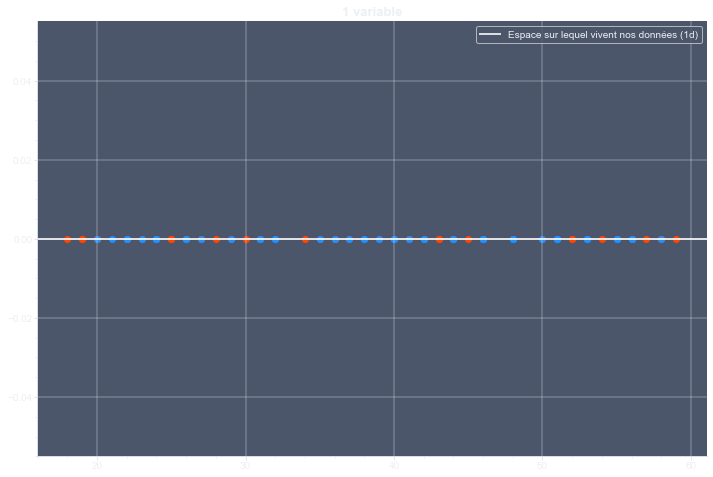

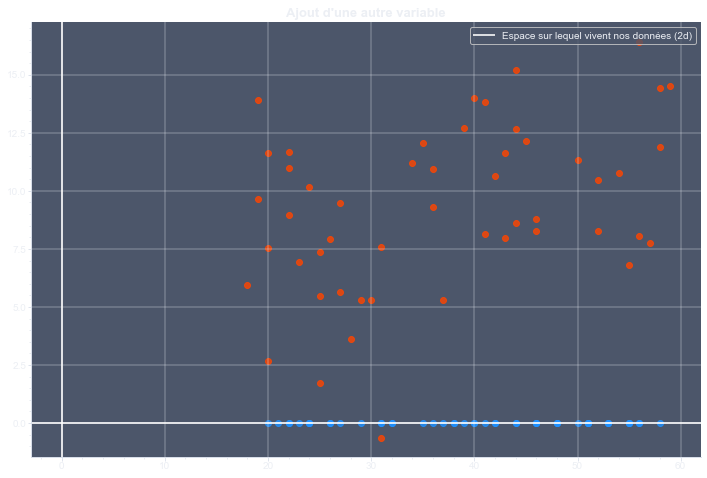

In [2]:
sample = np.random.randint(18, 60, size = 100)
target = np.random.randint(low = 0, high = 2, size = 100)


plt.figure(figsize = (12, 8))
plt.axhline(0, color = "white", alpha = .8, lw = 2, label = "Espace sur lequel vivent nos données (1d)")
plt.scatter(y = [0] * sample[target == 1].shape[0], x = sample[target == 1], color = "orangered", alpha = 1)
plt.scatter(y = [0] * sample[target == 0].shape[0], x = sample[target == 0], color = "dodgerblue", alpha = 1)
plt.title("1 variable", fontsize = 13, fontweight = "bold")
plt.legend()
plt.show()

second_variable = target * np.random.normal(loc = 10, scale = 3, size = 100)

plt.figure(figsize = (12, 8))
plt.axhline(0, color = "white", alpha = .8, lw = 2, label = "Espace sur lequel vivent nos données (2d)")
plt.axvline(0, color = "white", alpha = .8, lw = 2)
plt.scatter(y = second_variable[target == 1], x = sample[target == 1], color = "orangered", alpha = .8)
plt.scatter(y = second_variable[target == 0], x = sample[target == 0], color = "dodgerblue", alpha = .8)
plt.title("Ajout d'une autre variable", fontsize = 13, fontweight = "bold")
plt.legend(loc = "upper right")
plt.show()

In [3]:
data = pd.read_csv("data/train.csv", index_col="datetime")
data.index = pd.to_datetime(data.index)
one_dim_data = data.loc[:, "nat_demand"]

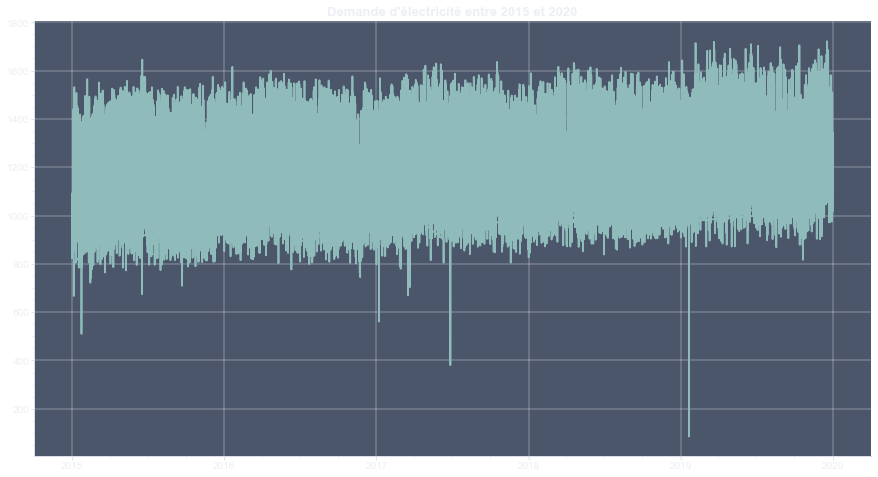

In [4]:
plt.figure(figsize = (15, 8))
plt.title("Demande d'électricité entre 2015 et 2020", fontsize = 13, fontweight = "bold")
plt.plot(one_dim_data.index, one_dim_data.values)
plt.show()

In [5]:
hourly_data = pd.DataFrame()
hourly_data.index = np.unique(one_dim_data.index.date)

for hour in [x for x in one_dim_data.index.hour.unique() if x != 0]:
    hourly = one_dim_data.iloc[one_dim_data.index.hour == hour].values
    hourly_data[hour] = hourly

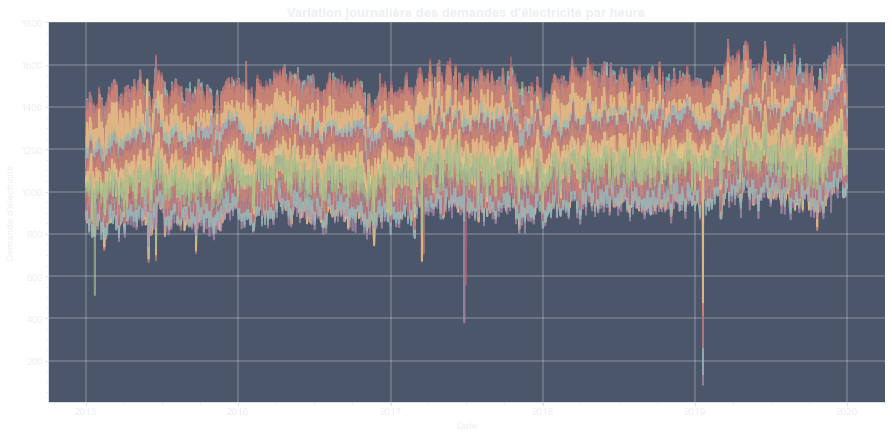

In [6]:
plt.figure(figsize = (15, 7))
for colonne in hourly_data.columns:
    plt.plot(hourly_data.index, hourly_data[colonne], alpha = .7)
plt.title("Variation journalière des demandes d'électricité par heure", fontsize = 13, fontweight = "bold")
plt.xlabel("Date")
plt.ylabel("Demande d'électricité")
plt.show()

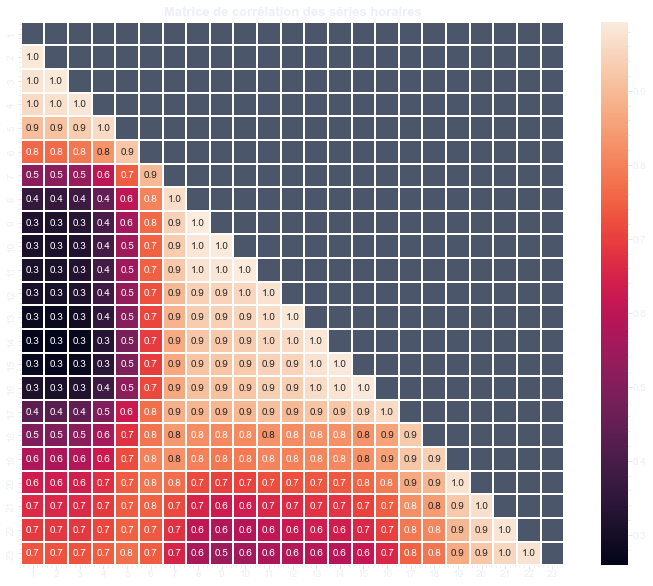

In [7]:
corr = hourly_data.corr()

plt.figure(figsize = (13, 10))
plt.title("Matrice de corrélation des séries horaires", fontsize = 13, fontweight = "bold")
sns.heatmap(data = corr, 
            fmt = ".1f", 
            mask = np.triu(corr), 
            linewidths=2,
            annot=True,
            cmap = "rocket",
            square=True)
plt.show()

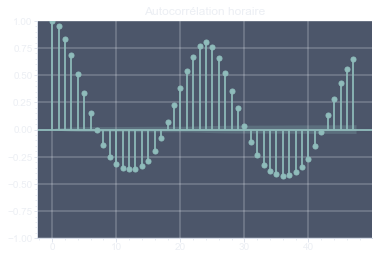

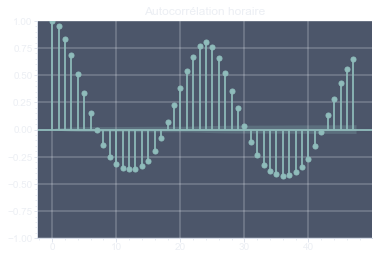

In [8]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(one_dim_data, title="Autocorrélation horaire")

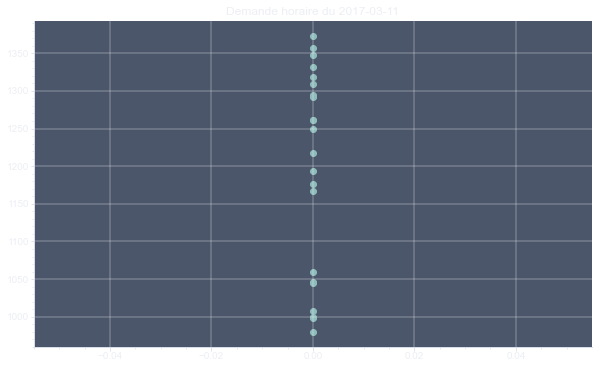

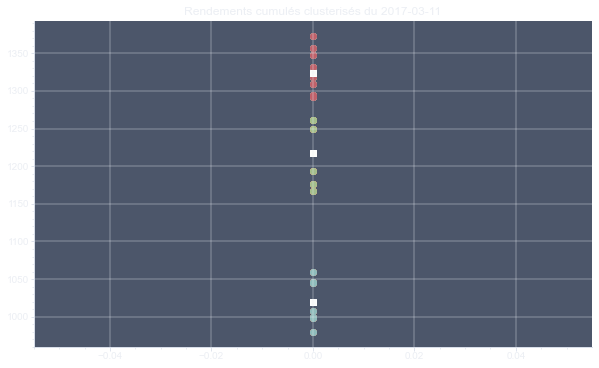

In [9]:
random_date = np.random.choice(hourly_data.index, size = 1)

plt.figure(figsize=(10, 6))
plt.title(f"Demande horaire du {random_date[0]}")
plt.scatter(x = [0] * hourly_data.shape[1], y = hourly_data.loc[random_date])
plt.show()

kmeans = KMeans(n_clusters = 3)
X = hourly_data.loc[random_date].values.reshape(-1, 1)
kmeans.fit(X = X)

plt.figure(figsize = (10, 6))
plt.title(f"Rendements cumulés clusterisés du {random_date[0]}")
for label in kmeans.labels_:
    plt.scatter([0] * X[kmeans.labels_ == label].shape[0], X[kmeans.labels_ == label])
for coord in kmeans.cluster_centers_:
    plt.scatter([0] * len(kmeans.cluster_centers_), kmeans.cluster_centers_, s = 30, color = "white",
                marker = "s", alpha = .7)
plt.show()

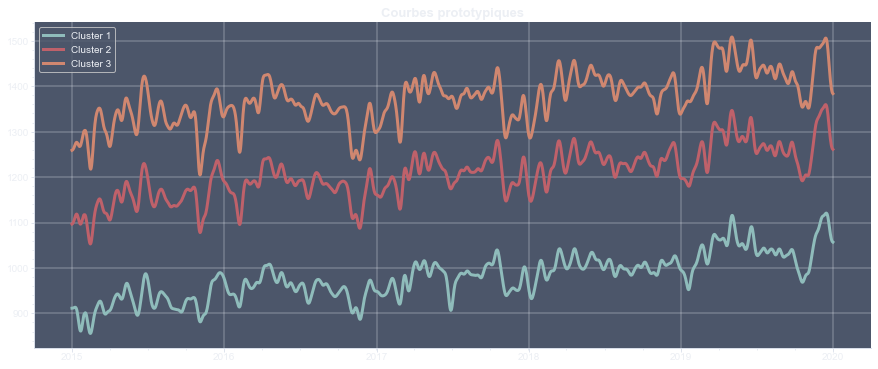

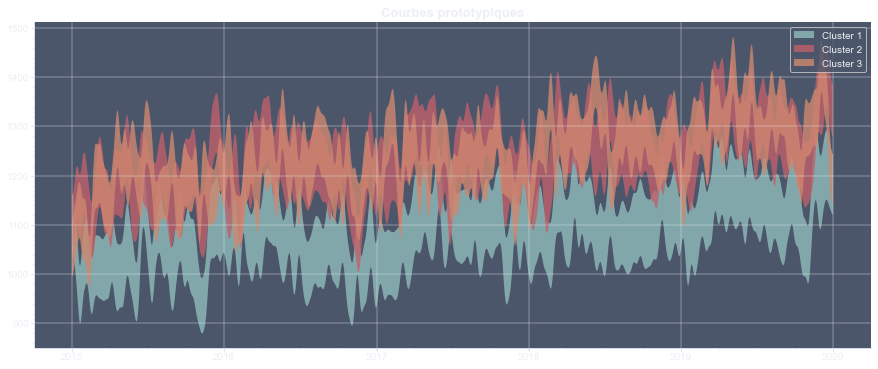

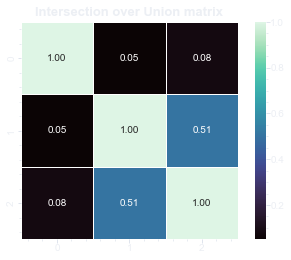

In [10]:
n_clusters = 3
tkm = TemporalKmeans(KMeans(n_clusters = n_clusters))
tkm.fit(X = hourly_data.values)

plot_prototypes(index = hourly_data.index, tkm = tkm)
plot_prototypes_intervals(hourly_data.index, tkm)

iou_matrix = compute_iou_matrix(tkm)  
plot_iou_matrix(iou_matrix)

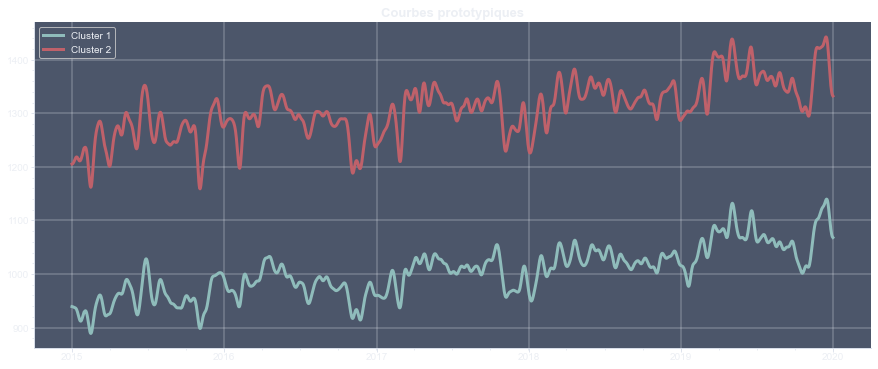

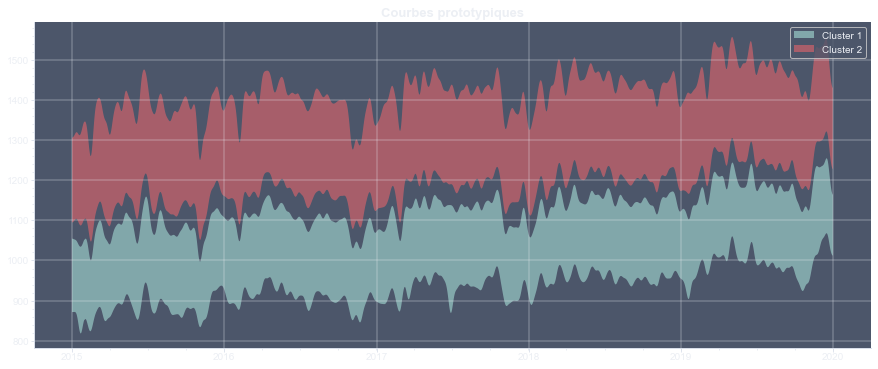

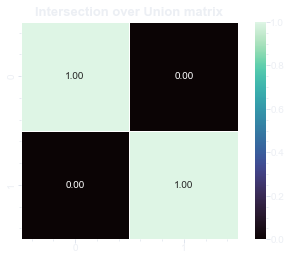

In [11]:
n_clusters = 2
tkm = TemporalKmeans(KMeans(n_clusters = n_clusters))
tkm.fit(X = hourly_data.values)

plot_prototypes(index = hourly_data.index, tkm = tkm)
plot_prototypes_intervals(hourly_data.index, tkm)

iou_matrix = compute_iou_matrix(tkm)  
plot_iou_matrix(iou_matrix)

In [12]:
from scipy import stats

labels = stats.mode(tkm.labels, axis = 0)[0].ravel()

results_df = pd.DataFrame()
results_df["Heure"] = hourly_data.columns
results_df["Cluster"] = labels+1

results_df.sort_values(by =[ "Cluster", "Heure"])

,Heure,Cluster
0,1,1.0
1,2,1.0
2,3,1.0
3,4,1.0
4,5,1.0
5,6,1.0
6,7,1.0
22,23,1.0
7,8,2.0
8,9,2.0


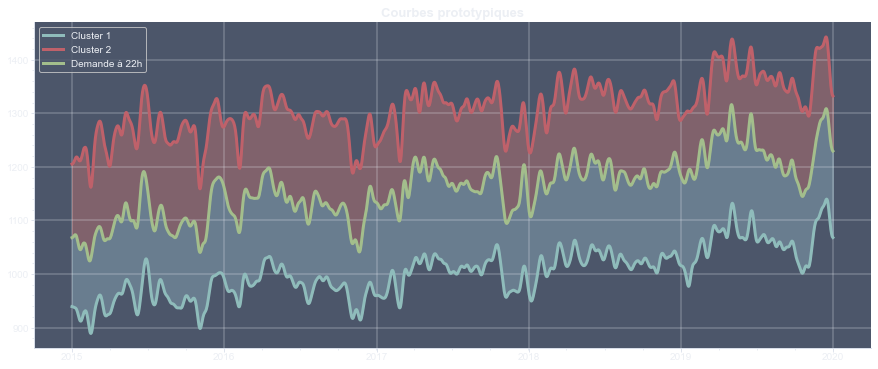

In [13]:
from scipy.ndimage import gaussian_filter1d

plt.figure(figsize = (15, 6))
plt.title("Courbes prototypiques", fontsize = 13, fontweight = "bold")

for i in range(tkm.centroids.shape[1]): 
    plt.plot(hourly_data.index, 
             gaussian_filter1d(tkm.centroids[:, i], sigma = 5), 
             lw = 3,
             label = [f"Cluster {cluster_nb}" for cluster_nb in np.arange(start = 1, 
                                                                          stop = tkm.centroids.shape[1]+1,
                                                                          step = 1)][i])

plt.plot(hourly_data.index, gaussian_filter1d(hourly_data[22], sigma=5), 
         lw = 3, label = "Demande à 22h", color = "C4")

plt.fill_between(x = hourly_data.index, 
                 y1 = gaussian_filter1d(hourly_data[22], sigma=5), 
                 y2 = gaussian_filter1d(tkm.centroids[:, 0], sigma = 5),
                 alpha = .3,
                 color = "lightblue")

plt.fill_between(x = hourly_data.index, 
                 y1 = gaussian_filter1d(hourly_data[22], sigma=5), 
                 y2 = gaussian_filter1d(tkm.centroids[:, 1], sigma = 5),
                 alpha = .3,
                 color = "salmon")
plt.legend()
plt.show()

In [14]:
proba_1, proba_2 = tkm.predict(hourly_data[22].values)
print(f"La probabilité pour que la demande soit associée au cluster 1 est de {proba_1:.2f}\n\
La probabilité pour que la demande soit associée au cluster 2 est de {proba_2:.2f}")

La probabilité pour que la demande soit associée au cluster 1 est de 0.49
La probabilité pour que la demande soit associée au cluster 2 est de 0.51


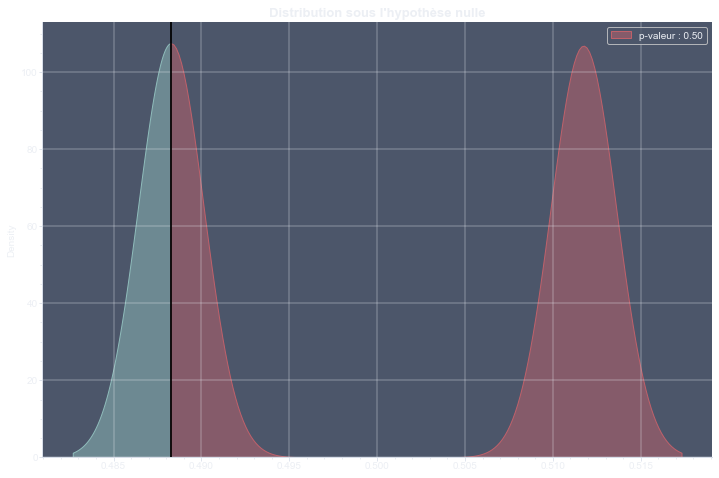

In [15]:
proba_1_list = list(); proba_2_list = list()
for i in range(10000):
    tkm.centroids = tkm.centroids[:, np.random.permutation(tkm.centroids.shape[1])]
    permuted_proba_1, permuted_proba_2 = tkm.predict(hourly_data[22].values)
    proba_1_list.append(permuted_proba_1); proba_2_list.append(permuted_proba_2)

proba_1_list = np.array(proba_1_list); proba_2_list = np.array(proba_2_list)
pval = np.sum(proba_1_list > proba_1)/len(proba_1_list)

plt.figure(figsize = (12, 8))
plt.title("Distribution sous l'hypothèse nulle", fontsize = 13, fontweight = "bold")
sns.kdeplot(proba_1_list, shade=True, cmap='coolwarm', thresh=0.05, clip=[None, proba_1], alpha=0.5)
sns.kdeplot(proba_1_list, shade=True, cmap='coolwarm', thresh=0.0, clip=[proba_1, None], alpha=0.5, label = f"p-valeur : {pval:.2f}")
plt.axvline(x = proba_1, color = "black")
plt.legend()
plt.show()